In [141]:
import numpy as np
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import math

from utils_data import *
import numpy as np

root_folder = './images/'
json_file = './images/gt.json'

# Load all the images and GT
train_imgs, train_class_labels, train_color_labels, test_imgs, test_class_labels, \
    test_color_labels = read_dataset(root_folder=root_folder, gt_json=json_file)

# List with all the existent classes
classes = list(set(list(train_class_labels) + list(test_class_labels)))

# Load extended ground truth
imgs, class_labels, color_labels, upper, lower, background = read_extended_dataset()
cropped_images = crop_images(imgs, upper, lower)

(180, 80, 60, 3)
(180,)


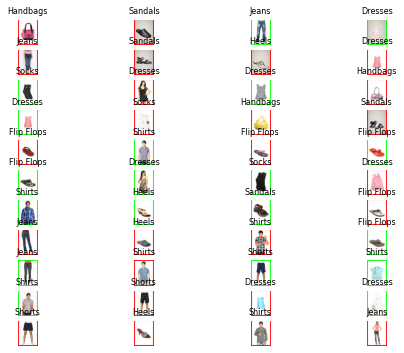

In [142]:
# Prova

# using the function visualize_retrieval for the visualization of the retrieval results. Pass the class labels as information to be displayed
predicted = np.random.choice([True, False], len(cropped_images))
print(imgs.shape)
print(cropped_images.shape)
visualize_retrieval(imgs, topN=44, info=class_labels, ok=predicted)

## 4.1: Funcions d’anàlisi qualitatiu

### Retrieval_by_color (Aleix)

In [143]:
# Code

### Retrieval_by_shape (Jan)

In [144]:
# Code

### Retrieval_combined (Aleix)

In [145]:
# Code

## Funcions d’anàlisi quantitatiu

### Kmean_statistics

<b>Enunciat de la prèvia</b>
Funció que rep com a entrada la classe Kmeans amb un conjunt d’imatges i un valor, Kmax, que representa la màxima K que volem analitzar. Per cada valor des de K=2 fins a K=Kmax executarà la funció fit i calcularà la WCD, el nombre d’iteracions i el temps que ha necessitat per convergir, etc. Finalment, farà una visualització amb aquestes dades.

<b>Implementació propia</b>

El que hem fet ...

In [235]:
# Aquesta funció serveix per a fer 3 plots, de la heurística 
def plot_wcd_iter_temps_and_means(heur = None, iter=None, temps=None, Kmax=10, nom_heur='Heurística'):
    
    # Aquesta comanda serveix per a dir el nombre de columnes i files dels plots, a més de les dimensions de tot plegat
    fig, ax = plt.subplots(1, 3, figsize=(20, 20))
    
    # Avans de mostrar qualsevol dada comprovo que aquesta existeixi 
    if heur is not None:
        
        # Primer mostrem totes les dades en "linies" individuals
        
        i = 0   # i serveix per a controlar l'index i actualitzar el label de la imatge
        max_height = max(heur[0])   # max_height serveix per a trobar el valor màxim del plot, és util per a mesurar les dimensions del cada plot
        
        # itero per cada element de la mètrica en questió, el mostro i actualitzo max_height si s'escau
        for h in heur:
            # aquesta funció afegeix a la figura ax[0][0] la recta h, notem que es guarden les rectes anteriorment asignades a ax[0][0]
            ax[0].plot(range(2,2+Kmax-1), h, label=f'imatge{i}', linestyle='dotted', ) # el range(...) indica de on a on va l'eix X
            
            # Busquem si hi ha la major altura i augmentem i
            if max_height < max(h):
                max_height = max(h)
            i+=1
        
        # Acontinuació fem i mostrem la mitjana de totes les linies
        heur_array = np.array(heur)
        means = np.mean(heur_array, axis=0)
        ax[0].plot(range(2,2+Kmax-1), means, label='Average heurístic value', linewidth=2, color='black')
        
        
        # Poso titols al plot i als eixos, i mostro la llegenda
        ax[0].set_title(nom_heur + ' per K')
        ax[0].set_xlabel('K')
        ax[0].set_ylabel(nom_heur)
        
        # Mostrem la llegenda en cas de que hi hagin poques linies
        if(len(heur) <= 5):
            ax[0].legend() 
        
        # Aquí indico les dimensions del plot, per a que tingui una forma ben maca :)
        ax[0].set_aspect(aspect=Kmax/max_height)
        ax[0].figure.set_size_inches(20, 20)
        
            
    if iter is not None:

        i, max_height = 0, max(iter[0])
        for it in iter:
            ax[1].plot(range(2,2+Kmax-1), it, label=f'imatge{i}', linestyle='dotted',)
            
            if max_height < max(it):
                max_height = max(it)
            i += 1
            
        iter_array = np.array(iter)
        means = np.mean(iter_array, axis=0)  
        ax[1].plot(range(2,2+Kmax-1), means, label='Average iterations', linewidth=2, color='black') 
            
        ax[1].set_title('Number of iterations needed per K')
        ax[1].set_xlabel('K')
        ax[1].set_ylabel('# Iterations')
        
        if(len(iter) <= 5):
            ax[1].legend() 
        
        ax[1].set_aspect(aspect=Kmax/max_height)
        ax[1].figure.set_size_inches(20, 20)
        
  
    
    if temps is not None:
        i, max_height = 0, max(temps[0])
        for t in temps:
            ax[2].plot(range(2,2+Kmax-1), t, label=f'imatge{i}',linestyle='dotted')
            if max_height < max(t):
                max_height = max(t)
            i += 1
        
        time_array = np.array(temps)
        means = np.mean(time_array, axis=0)
        ax[2].plot(range(2,2+Kmax-1), means, label='Average fit time',linewidth=2, color='black')
        
        
        ax[2].set_title('Execution time of each Kmeans fit')
        ax[2].set_xlabel('K')
        ax[2].set_ylabel('Time')
        
        if(len(temps) <= 5):
            ax[2].legend() 
            
        ax[2].set_aspect(aspect=Kmax/max_height)
        ax[2].figure.set_size_inches(20, 20)

    
    
    # Ajusto l'espai que hi ha entre plots per a que es vegi bé
    plt.subplots_adjust(wspace=.7) 

    plt.show()

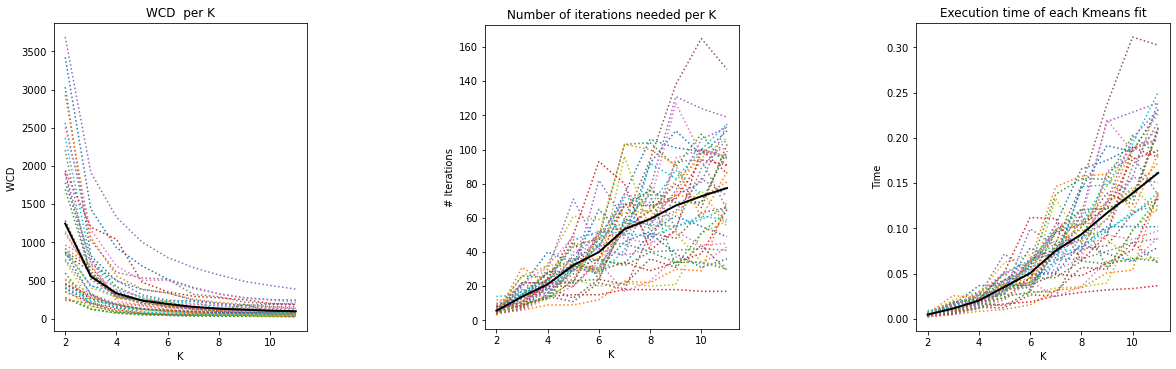

In [243]:
from Kmeans import KMeans
import time
import pickle

# Aquesta funció avaluarà la funcuó fit, d'una fomrma semblant a la que implenentariem un find_best_k()
def Kmean_statistics(kmeans, imgs, kmax):
    
    wcd, iter, temps = [], [], []
    
    # Fem un model fit per a cada K diferent dins del rang [2, Kmax] i en guardem les mètriques demanades
    for i in range(2, kmax+1):
        kmeans.num_iter = 0
        kmeans.K = i
        
        # calculem el temps que es triga en fer el fit (en segons)
        start_time = time.time()
        kmeans.fit()
        end_time = time.time()
        
        
        wcd.append(kmeans.withinClassDistance())
        iter.append(kmeans.num_iter)
        temps.append(end_time - start_time)   
    
    return wcd, iter, temps




# Creem les llistes de dades i executem la funció Kmean_statistics per cada imatge 
Kmax = 11
wcd_lst, iter_lst, temps_lst = [], [], []
#for ix, input in enumerate(test_cases['input']):
for input in imgs[0:40]:
    
    # Inicialitzem una nova classe K-Means amb la nova imatge
    km = KMeans(input)
    
    # Calculem les estadístiques
    wcd, iter, temps = Kmean_statistics(km, None ,kmax=Kmax)
    
    wcd_lst.append(wcd)
    iter_lst.append(iter)
    temps_lst.append(temps)
    
    # Les següents 2 instuccions comentades mostren la el nuvol de punts 3D de la figura
    #km.fit()
    #visualize_k_means(km, input.shape)
    
# Mostrem el resultat 
plot_wcd_iter_temps_and_means(heur=wcd_lst, iter=iter_lst, temps=temps_lst, Kmax=Kmax, nom_heur='WCD ')

### Get_shape_accuracy (Aleix)

In [237]:
# Code 

### Get_color_accuracy (Jan)

In [238]:
# Code

## Millores als mètodes de classificació

### Inicializations de Kmeans

In [239]:
# Code

### Diferents heurístiques per BestK

In [240]:
# Code

### Find_BestK

In [241]:
# Code

### Features for KNN

In [242]:
# Code